# Camera Calbration

Here I will consider the rubric points individually and describe how I addressed each point in
my implementation.

## Have the camera matrix and distortion coefficients been computed correctly and checked on one of the calibration images as a test?

This part is based upon - https://github.com/udacity/CarND-Camera-Calibration

### Imports

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

plt.style.use('seaborn-white')

### Setup Variables

In [2]:
inner_chessboard_corners = (9,6)
camera_calibration_images = 'camera_cal/calibra*.jpg'
camera_calibration_pickle = 'dist_pickle.p'
camera_calibration_example = 'camera_cal/calibration1.jpg'
camera_calibration_example_out = 'output_images/calibration1_undist.jpg'

### Create objpoints & imgpoints

First I've loaded all the calibration images and used them to create objpoints and imgpoints objects, using cv2.findChessboardCorners() on thegrayscaled versions of all images.

In [3]:
objp = np.zeros((inner_chessboard_corners[1]*inner_chessboard_corners[0],3), np.float32)
objp[:,:2] = np.mgrid[0:inner_chessboard_corners[0], 0:inner_chessboard_corners[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob(camera_calibration_images)

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, inner_chessboard_corners, None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


### Output Original & Undistorted Chessboard

Now I'm using the generated objects in  cv2.calibrateCamera() to create calibration and distortion coefficents (mtx and dist). 

Now I'm able to undist an test image using cv2.undistort()

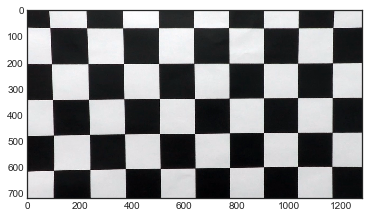

In [4]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread(camera_calibration_example)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite(camera_calibration_example_out,dst)

plt.imshow(dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)

In [5]:
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["objpoints"] = objpoints
dist_pickle["imgpoints"] = imgpoints

pickle.dump( dist_pickle, open(camera_calibration_pickle, "wb" ) )

# Visualize undistortion

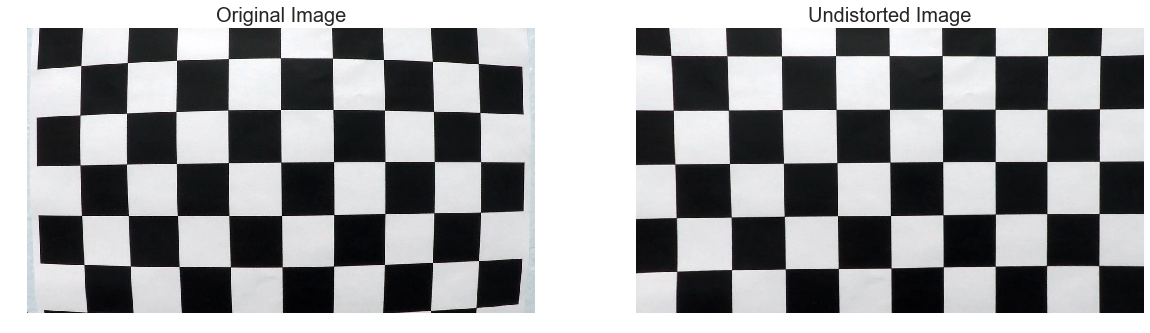

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.axis('off')
ax2.set_title('Undistorted Image', fontsize=20)

Finall i've create a undistorted version of the input image.

# Pipeline (single images)

This part is my own implementation, following the lectures and applying differnent kind of variables.

### Imports

In [7]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Setup Variables

In [8]:
test_image = "test_images/test5.jpg"
test_image_output = "output_images/test5_undist.jpg"
dashboard_crop = 50

### Load dist_pickle

Load the saved pickle, which saves us creating a new calibration.

In [9]:
dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

### Image processing pipeline functions

The first pipeline i've created takes an image, calbration and distortion coefficents. It also supports adding an dashboard_crop attribute, which crops away data from the bottom of the image.

It returns a an undistored version of the input image.

In [10]:
def pipeline(img, mtx, dist, dashboard_crop=50):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    crop = dst[0:dst.shape[0]-dashboard_crop, 0:dst.shape[1]]
    
    return crop

## 1. Has the distortion correction been correctly applied to each image?

In [11]:
# Test undistortion on an image and write it to disk
img = cv2.imread(test_image)

dst = pipeline(img, mtx, dist)
cv2.imwrite(test_image_output, dst)

True

### Visualize undistortion

Now i've taken one of the example images and run it through my pipeline. In this example, you can see the cropped away engine cover andthe undistorted trees.

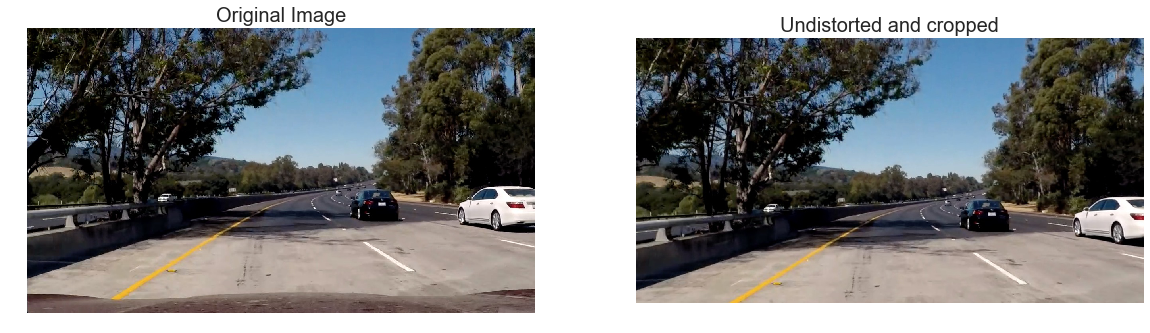

In [12]:
img = mpimg.imread(test_image)
test_img = mpimg.imread(test_image_output)

%matplotlib inline
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(test_img, cmap='gray')
ax2.axis('off')
ax2.set_title('Undistorted and cropped', fontsize=20)


## Has a binary image been created using color transforms, gradients or other methods?

### Imports

In [13]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

### Setup Variables

In [14]:
test_undist = "output_images/test5_undist.jpg"
test_undist_gradx = "output_images/test5_undist_gradx.jpg"
test_undist_grady = "output_images/test5_undist_grady.jpg"
test_undist_mag_binary = "output_images/test5_undist_mag_binary.jpg"
test_undist_dir_binary = "output_images/test5_undist_dir_binary.jpg"
test_undist_color_binary = "output_images/test5_undist_color_binary.jpg"
test_undist_combined = "output_images/test5_undist_combined.jpg"

### Create combined threshold

Next step on my journey of advanced lane finding was to build a set of helper functions, we've learned about during the chapters leading to the project.

The functions are more or less copies of the functions in the chapters.

In [15]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    else:
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        
    abs_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(abs_sobel)
    binary_output[(abs_sobel >= thresh[0]) & (abs_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [16]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


In [17]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [18]:
def color_thresh(img, s_thresh=(200, 255), sx_thresh=(50, 100)):
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    return color_binary

In [19]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    bin = np.zeros_like(S)
    bin[(S > thresh[0]) & (S <= thresh[1])] = 1
    return bin

In [20]:
def bin_to_rgb(bin_image):
    return cv2.cvtColor(bin_image*255, cv2.COLOR_GRAY2RGB)

In [21]:
def hls_to_rgb(hlsimage):
    return cv2.cvtColor(hlsimage, cv2.COLOR_HLS2RGB)

In [22]:
def binary_noise_reduction(img, thresh=4):      
    k = np.array([
        [1, 1, 1],
        [1, 0, 1],
        [1, 1, 1]
    ])
    nb_neighbours = cv2.filter2D(img, ddepth=-1, kernel=k)
    img[nb_neighbours < thresh] = 0
    return img

In [23]:
def create_binary(img):
    img = np.copy(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply each of the thresholding functions
    gradx = binary_noise_reduction(abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=threshold))
    grady = binary_noise_reduction(abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=threshold))
    mag_binary = binary_noise_reduction(mag_thresh(img, sobel_kernel=mag_sobel_kernel, mag_thresh=mag_threshold))
    dir_binary = binary_noise_reduction(dir_threshold(img, sobel_kernel=binary_sobel_kernel, thresh=binary_mag_threshold))
    color_binary = binary_noise_reduction(color_thresh(img, s_thresh=s_thresh, sx_thresh=sx_thresh))
    
    return (gradx, grady, mag_binary, dir_binary, color_binary)

### Try out helpers

Now it is time to play around with the functions above. First I'm setting up the input variables for the functions and then I'm outputting the generated outputs below.

In [24]:
ksize = 5
threshold=(25, 80)

mag_sobel_kernel = 9
mag_threshold=(40, 100)

binary_sobel_kernel = 15
binary_mag_threshold=(0.7, 1.3)

s_thresh=(200, 255)
sx_thresh=(50, 100)

img = mpimg.imread(test_image_output)
gradx, grady, mag_binary, dir_binary, color_binary = create_binary(img)

True

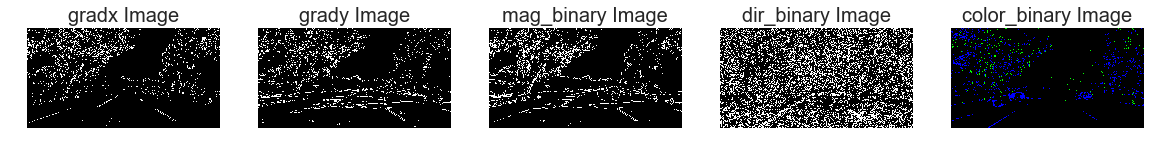

In [25]:
%matplotlib inline
# Visualize undistortion
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,10))
ax1.imshow(gradx, cmap='gray')
ax1.axis('off')
ax1.set_title('gradx Image', fontsize=20)
ax2.imshow(grady, cmap='gray')
ax2.axis('off')
ax2.set_title('grady Image', fontsize=20)
ax3.imshow(mag_binary, cmap='gray')
ax3.axis('off')
ax3.set_title('mag_binary Image', fontsize=20)
ax4.imshow(dir_binary, cmap='gray')
ax4.axis('off')
ax4.set_title('dir_binary Image', fontsize=20)
ax5.imshow(color_binary)
ax5.axis('off')
ax5.set_title('color_binary Image', fontsize=20)

cv2.imwrite(test_undist_gradx, bin_to_rgb(gradx))
cv2.imwrite(test_undist_grady, bin_to_rgb(grady))
cv2.imwrite(test_undist_mag_binary, bin_to_rgb(mag_binary))
cv2.imwrite(test_undist_dir_binary, bin_to_rgb(np.uint8(dir_binary)))
cv2.imwrite(test_undist_color_binary, np.uint8(color_binary)) # Don't know, why the written file is just black....

## Build Pipeline 

After playing around with the helper functions and getting a feeling about which mask/filter techniques play well together, I started to create my final image pipeline.

The pipeline consists of four steps:
* Create a HLS version of the input image
* Get the stauration and lightning channels out of hls
* run the result from the lightning channel through our absolute sobel function
* threshold the l- and s channels
* combine the binary images together
* remove binary noise

True

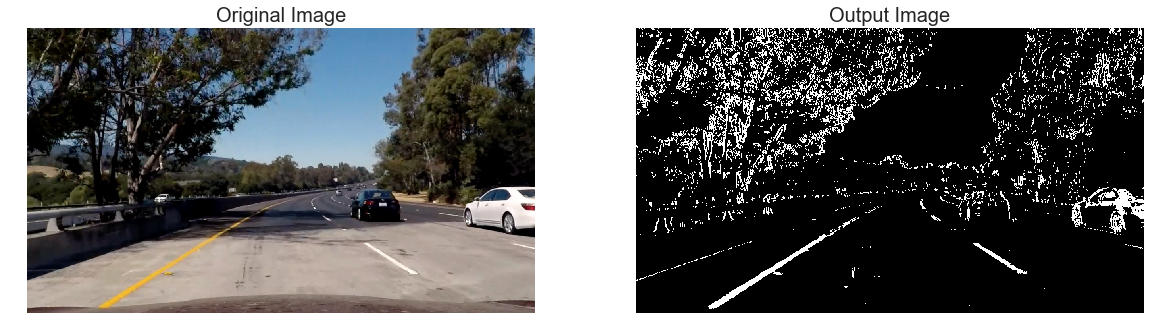

In [26]:
def pipeline(img):    
    thresh_s = (120, 255)
    thresh_l = (40, 255)
    thresh_sobel = (20, 255)
    
    # thresh_mag = (0, 255)
    # thresh_dir = (0, 255)

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) 
    l_channel = hls[:,:,1]       
    s_channel = hls[:,:,2]

    # Gradient, Magnitude, Direction Thresholds
    gradx = abs_sobel_thresh(l_channel, orient='x', thresh=thresh_sobel)
    # mag_bin = mag_thresh(img, sobel_kernel=ksize, mag_thresh=thresh_mag)
    # dir_bin = dir_threshold(img, sobel_kernel=ksize, thresh=thresh_dir)
    
    # Threshold l (lightness) channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= thresh_l[0]) & (l_channel <= thresh_l[1])] = 1
    
    # Threshold s (saturation) channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh_s[0]) & (s_channel <= thresh_s[1])] = 1
    
    # Combined Binary
    combined = np.zeros_like(gradx)
    combined[(((l_binary == 1) & (s_binary == 1)) | (gradx == 1))] = 1
    
    unnoised = binary_noise_reduction(combined)
    
    return unnoised

dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

img = mpimg.imread(test_image)
undist = cv2.undistort(img, mtx, dist, None, mtx)
output = pipeline(undist)

draw = np.uint8(255*np.dstack((output, output, output)))

%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(draw)
ax2.axis('off')
ax2.set_title('Output Image', fontsize=20)
cv2.imwrite(test_undist_combined, bin_to_rgb(output))

The output shows a pretty clear image of the lane lines. I've choosen an image of the section my algorithm in the first lane finding project failed miserably. So I'm pretty with my result, as the resulting images clearly outputs the lane lines.

There are a trillion ways to combine the different functions and thresholds. This was the result, I felt most comfortably with.

## Has a perspective transform been applied to rectify the image?

### Setup Variables

In [27]:
test_straight_lines1 = 'test_images/straight_lines1.jpg'
test_straight_lines1_output = 'output_images/straight_lines1_output.jpg'


test_binary_warped = 'output_images/test3_test_binary_warped.jpg'

### Perspective transform

My code for the perspective transformation creates a function warp, that takes athe following arguments:

* img - input image
* M – 3*3 transformation matrix

The function just reads the image size and returns the warped output image using cv2.warpPerspective().

The paramater M is being calculated with cv2.getPerspectiveTransform() using two points I've selected from the a simple image with straight lines.

In [28]:
def warp(img, M):
    img_size = (img.shape[1], img.shape[0])
    
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

True

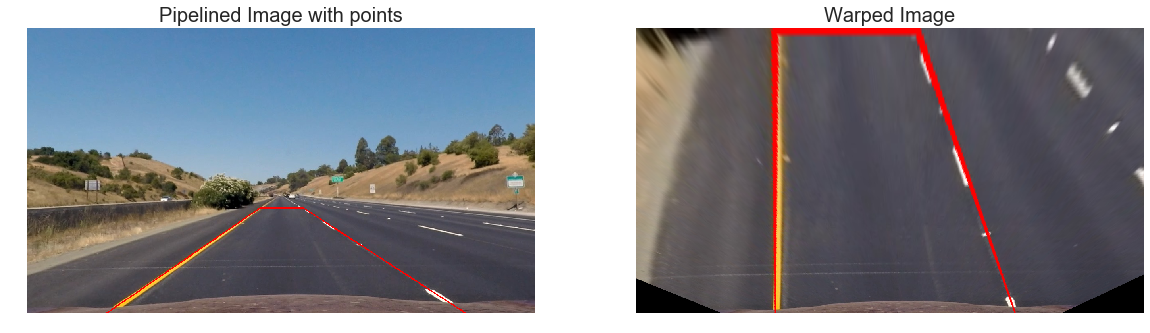

In [29]:
dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

src = np.float32([
    (200, 720),
    (587, 455),
    (696, 455),
    (1105, 720)])

dst = np.float32([
    (src[0][0] + 150, 720),
    (src[0][0] + 150, 0),
    (src[-1][0] - 400, 0),
    (src[-1][0] - 150, 720)])

a = tuple(src[0])
b = tuple(src[1])
c = tuple(src[2])
d = tuple(src[3])

M = cv2.getPerspectiveTransform(src, dst)

dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

img = mpimg.imread(test_straight_lines1)
undist = cv2.undistort(img, mtx, dist, None, mtx)

line_color=[255, 0, 0]
line_thickness=2
cv2.line(undist, a, b, line_color, line_thickness)
cv2.line(undist, b, c, line_color, line_thickness)
cv2.line(undist, c, d, line_color, line_thickness)
cv2.line(undist, d, a, line_color, line_thickness)

undist_warped = warp(undist, M)

%matplotlib inline
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(undist)
ax1.axis('off')
ax1.set_title('Pipelined Image with points', fontsize=20)

ax2.imshow(undist_warped)
ax2.axis('off')
ax2.set_title('Warped Image', fontsize=20)
cv2.imwrite(test_straight_lines1_output, undist_warped)

### Pipeline with combined binary

Now i'm trying my warp function with a binary image and the whole pipline.

True

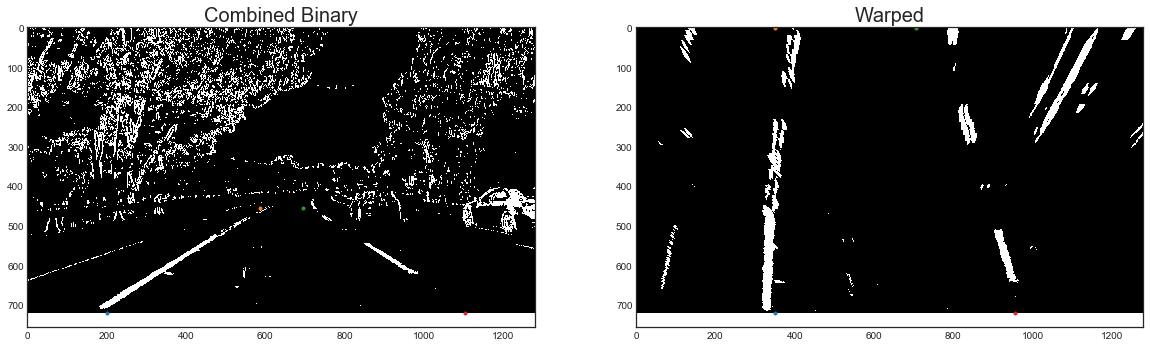

In [30]:
dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

img = mpimg.imread(test_image)
img_warped = mpimg.imread(test_image)
undist = cv2.undistort(img, mtx, dist, None, mtx)
undist_warped = warp(undist, M)
binary = pipeline(undist)
binary_warped = warp(binary, M)

%matplotlib inline
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(binary, cmap="gray")
ax1.plot(src[0][0], src[0][1], '.') # top right
ax1.plot(src[1][0], src[1][1], '.') # bottom right
ax1.plot(src[2][0], src[2][1], '.') # bottom left
ax1.plot(src[3][0], src[3][1], '.') # top left

ax1.set_title('Combined Binary', fontsize=20)

ax2.imshow(binary_warped, cmap="gray")
ax2.plot(dst[0][0], dst[0][1], '.') # top right
ax2.plot(dst[1][0], dst[1][1], '.') # bottom right
ax2.plot(dst[2][0], dst[2][1], '.') # bottom left
ax2.plot(dst[3][0], dst[3][1], '.') # top left
ax2.set_title('Warped', fontsize=20)

cv2.imwrite(test_binary_warped, bin_to_rgb(binary_warped))

## Have lane line pixels been identified in the rectified image and fit with a polynomial?

### Setup Variables

In [31]:
test_histogram = "output_images/test5_histogram.jpg"
test_sliding_window = "output_images/test5_sliding_window.jpg"
test_skip_sliding_window = "test_images/test4.jpg"
test_skip_sliding_window_output = "output_images/test4_sliding_window.jpg"
test_fake_data_output = "output_images/test4_fake_data.jpg"
test_overlay_output = "output_images/test4_overlay.jpg"
test_composed_output = "output_images/test4_composed.jpg"

### Line Finding Method: Peaks in a Histogram

I'm using a histogram to find peaks in the lower half of the image.

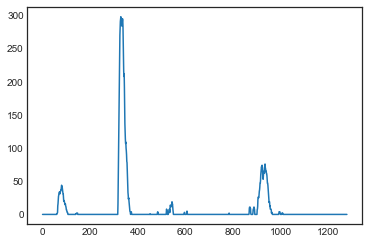

In [32]:
dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

img = mpimg.imread(test_image)
img_warped = mpimg.imread(test_image)
undist = cv2.undistort(img, mtx, dist, None, mtx)
binary = pipeline(undist)
binary_warped = warp(binary, M)

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.savefig(test_histogram)


the peaks are being found using np.argmax() function on the left and right half of the image.

In [33]:
midpoint = np.int(histogram.shape[0] / 2)

# get left and right halves of the histogram
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print('Left Peak: {}'.format(leftx_base))
print('Right Peak: {}'.format(rightx_base))

Left Peak: 329
Right Peak: 935


### Sliding Window

Now I'm going to merge the learnings from above into some more helper functions.

* histogram_peaks() - takes an image an returns peaks for the left and right half and the used midpoint
* find_sliding_window() - takes an image and returns a image and the found polynoms


Based on - https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/c41a4b6b-9e57-44e6-9df9-7e4e74a1a49a

In [34]:
from scipy.signal import medfilt

def histogram_peaks(image):
    histogram = np.sum(image[int(image.shape[0]/2):,:], axis=0)
    x_margins = (int(image.shape[1]*0.08), int(image.shape[1]*0.92))
    
    idx = [i for i in range(histogram.shape[0]) if i < x_margins[0] or i > x_margins[1]]
    histogram[idx] = 0    
    histogram = medfilt(histogram, 7)
    
    midpoint = np.int(histogram.shape[0]/2)
    left_base_x = np.argmax(histogram[:midpoint])
    right_base_x = np.argmax(histogram[midpoint:]) + midpoint

    return left_base_x, right_base_x, midpoint

def find_sliding_window(binary_warped):
    leftx_base, rightx_base, midpoint = histogram_peaks(binary_warped)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = (
            (nonzeroy >= win_y_low) & 
            (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) & 
            (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = (
            (nonzeroy >= win_y_low) & 
            (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) & 
            (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, left_fit, left_fitx, right_fit, right_fitx, ploty

Finally I'm able to output the binary warped image and the found slinding windows and polynoms.

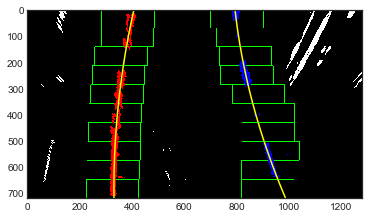

In [35]:
dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

img = mpimg.imread(test_image)
img_warped = mpimg.imread(test_image)
undist = cv2.undistort(img, mtx, dist, None, mtx)
binary = pipeline(undist)
binary_warped = warp(binary, M)

out_img, left_fit, left_fitx, right_fit, right_fitx, ploty = find_sliding_window(binary_warped)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.savefig(test_sliding_window)

### Skip Sliding Window

To speed up processing of follow up images, the chapter tolds us to use a function, which takes in the sliding windows and looks for new polynoms in a smalled part of the image.

I was not able to use this function properly, that's why i've submitted two output videos.

* output_videos_with_skip_sliding_window/project_video_output.mp4 - which uses the skip sliding window version
* output_videos/project_video_output.mp4 - which always is running the full search, but works much better for me

The function itself is working on a simple image, as you can see below. 

I'd be happy to know, why the version with skipping does not work for me. But I was not able to get it working :(

In [36]:
def skip_sliding_window(binary_warped, left_fit, right_fit, margin = 125, quadratic_coeff = 3e-4):
    leftx_base, rightx_base, midpoint = histogram_peaks(binary_warped)
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    leftx = np.array([leftx_base + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
    rightx = np.array([rightx_base + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return out_img, left_fit, left_fitx, right_fit, right_fitx, ploty

(720, 0)

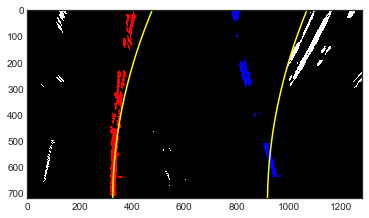

In [37]:
dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

img = mpimg.imread(test_image)
img_warped = mpimg.imread(test_image)
undist = cv2.undistort(img, mtx, dist, None, mtx)
binary = pipeline(undist)
binary_warped = warp(binary, M)

out_img, left_fit, left_fitx, right_fit, right_fitx, ploty = skip_sliding_window(binary_warped, left_fit, right_fit)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Having identified the lane lines, has the radius of curvature of the road been estimated? And the position of the vehicle with respect to center in the lane?


Now it is time to calculate curvature radius and the lane deviaton. 

Therefore I've add two more functions get_curve_rad() and get_lane_deviation() which return the values. The calculations are based on the chapters and the [U.S. government specifications for highway curvature](http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC).

In [38]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

print(left_curverad, right_curverad)

1757.88006226 1823.88917873


In [39]:
def curve_rad(fit, y):
    return ((1 + (2*fit[0]*y + fit[1])**2)**1.5) / np.absolute(2*fit[0])

def get_curve_rad(ploty, leftx, rightx, y_eval, xm_per_pix = 3.7/700, ym_per_pix = 21/720):
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return (left_curverad, right_curverad)

left_curverad, right_curverad = get_curve_rad(ploty, left_fitx, right_fitx, y_eval)
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

282.904465623 m 293.473351968 m


In [40]:
def get_lane_deviation(img, xm_per_pix = 3.7/700):
    center = img.shape[0] / 2
    lane_deviation = (center - img.shape[1] / 2.0) * xm_per_pix
    return lane_deviation;


print(get_lane_deviation(img), 'm')

-1.48 m


# Line Class

We need to find a way to hold state during, that's why I create the class LaneFinder.

## Process image

### Imports

In [41]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Setup Variables


In [42]:
test_image_class_1 = "test_images/test5.jpg"
test_image_class_2 = "test_images/test6.jpg"
test_image_class_3 = "test_images/test2.jpg"
test_image_class_1_output = "output_images/test5_pipeline.jpg"
test_image_class_2_output = "output_images/test6_pipeline.jpg"
test_image_class_3_output = "output_images/test6_pipeline.jpg"

### LaneFinder

Lane finder is being initalized with the calibration and distortion coefficents (mtx and dist) create earlier.

The LaneFinder is beeing feeded through the process() with images and calculates the data and images for the final output. The class uses the functions we created throughout the whole project.

The output images show, that the LaneFinder is working correctly. As I really mentioned above, I've had serious problems to use the skip sliding window mechanism from the chapters. But as you can see in the output videos, the LaneFinder which is always searching for the sliding windows works pretty well on the project video.

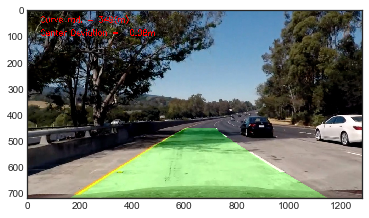

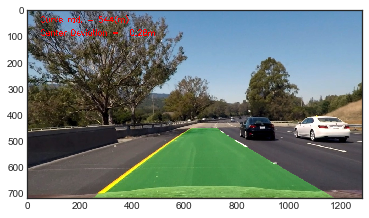

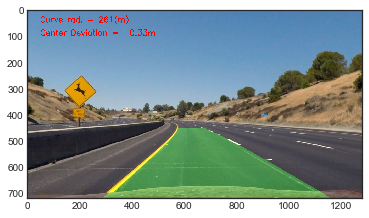

In [43]:
class LaneFinder:
    def __init__(self, mtx, dist):
        self.frames = 0
        self.mtx = mtx
        self.dist = dist
        
        self.ym_per_pix = 21/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        self.quadratic_coeff = 3e-4
        
        self.img = None
        self.undist = None
        self.binary = None
        self.binary_warped = None
        self.output = None
        
        self.avg_curverad = None
        self.left_curverad = None
        self.right_curverad = None
        self.offset = None
        
        self.fit_cr = None
        self.left_fit = None
        self.left_fitx = None 
        self.right_fit = None 
        self.right_fitx = None 
        self.ploty = None
        self.y_eval = None
        self.points = None
        
        self.center = None
        
        self.src = None
        self.dst = None
        
        self.M = None
        self.Minv = None
        
        self.buffer = 50
        
    def output_info(self, img):
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, 'Curve rad. = %d(m)' % self.avg_curverad, (50, 50), font, 1, (255, 0, 0), 2)
        cv2.putText(img, 'Center Deviation = %.2fm' % self.offset, (50, 100), font, 1, (255, 0, 0), 2)
        return img
        
    def generate_output(self):
        warp_zero = np.zeros(self.undist.shape[0:2], np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        cv2.fillPoly(color_warp, np.int_([self.points]), (0, 255, 0))
        
        img_size = (self.img.shape[1], self.img.shape[0])
        unwarped = warp(color_warp, self.Minv)
        result = cv2.addWeighted(self.undist, 1, unwarped, 0.3, 0)
        info = self.output_info(result)
        
        self.output = info
        
    def update(self, left_fit, left_fitx, right_fit, right_fitx, ploty):    
        points_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        points_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        points = np.hstack((points_left, points_right))

        if self.buffer < 50:
            a = 0.8 ** self.buffer
            self.points = a * self.points + (1-a) * points
            self.left_fit = a * self.left_fit + (1-a) * left_fit
            self.right_fit = a * self.right_fit + (1-a) * right_fit
        else:
            self.points = points
            self.left_fit = left_fit
            self.right_fit = right_fit  

        self.left_fitx = left_fitx 
        self.right_fitx = right_fitx 
        self.ploty = ploty

        y_eval = np.max(ploty)
        left_curverad, right_curverad = get_curve_rad(self.ploty, self.left_fitx, self.right_fitx, y_eval)

        self.left_curverad = left_curverad
        self.right_curverad = right_curverad
        self.avg_curverad = (left_curverad + right_curverad) / 2

        self.center = (left_fitx[-1] + right_fitx[-1]) / 2.0
        self.offset = ((self.img.shape[1]) / 2.0 - self.center) * self.xm_per_pix

    def process(self, img):
        self.img = np.copy(img)
        
        if self.src is None and self.dst is None:
            self.src = np.float32([
                (200, 720),
                (587, 455),
                (696, 455),
                (1105, 720)])

            self.dst = np.float32([
                (src[0][0] + 150, 720),
                (src[0][0] + 150, 0),
                (src[-1][0] - 150, 0),
                (src[-1][0] - 150, 720)])
            
            self.M = cv2.getPerspectiveTransform(self.src, self.dst)
            self.Minv = cv2.getPerspectiveTransform(self.dst, self.src)
            
        self.undist = cv2.undistort(self.img, self.mtx, self.dist, None, self.mtx)
        self.binary = pipeline(self.undist)
        self.binary_warped = warp(self.binary, self.M)
        
        try:
            raise Exception('Always sliding')  
            if self.left_fit is None and self.right_fit is None:
                raise Exception('No sliding window')  
            out_img, left_fit, left_fitx, right_fit, right_fitx, ploty = skip_sliding_window(self.binary_warped, self.left_fit, self.right_fit)
            
        except Exception as e:
            # When exception, fallback to sliding window
            try:
                out_img, left_fit, left_fitx, right_fit, right_fitx, ploty = find_sliding_window(self.binary_warped)
            except Exception as e:
                if self.output is not None:
                    return self.output
                else:
                    return self.undist
        self.out_img = out_img
        self.update(left_fit, left_fitx, right_fit, right_fitx, ploty)
        self.frames = self.frames + 1
        self.generate_output()
        
        return self.output

    
dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
   
laneFinder = LaneFinder(mtx, dist)

img1 = plt.imread(test_image_class_1)
img2 = plt.imread(test_image_class_2)
img3 = plt.imread(test_image_class_3)
output3 = laneFinder.process(img3)
output1 = laneFinder.process(img1)
output2 = laneFinder.process(img2)

plt.figure()
plt.imshow(output1)
plt.show()
plt.imshow(output2)
plt.show()
plt.imshow(output3)
plt.show()
plt.imsave(test_image_class_1_output, output1)
plt.imsave(test_image_class_2_output, output2)
plt.imsave(test_image_class_3_output, output3)

## Process video 

Finally I'm using the LaneFinder to handle the videos and output the submitted clips.

### Setup Variables

In [44]:
project_video = 'project_video.mp4'
challenge_video = 'challenge_video.mp4'
harder_challenge_video = 'harder_challenge_video.mp4'

project_video_output = 'output_videos/project_video_output.mp4'
challenge_video_output = 'output_videos/challenge_video_output.mp4'
harder_challenge_video_output = 'output_videos/harder_challenge_video_output.mp4'

### Project Video

In [45]:
dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

laneFinder = LaneFinder(mtx, dist)

clip = VideoFileClip(project_video)
# clip = clip.subclip(t_start=40, t_end=41)
# clip = clip.subclip(t_start=23, t_end=30)
# clip = clip.subclip(t_start=5, t_end=8)
# clip = clip.subclip(t_start=35, t_end=35.2)
# clip = clip.subclip(t_start=35, t_end=36)
print('Duration: ', clip.duration)
output_clip = clip.fl_image(lambda frame: laneFinder.process(frame))
output_clip.write_videofile(project_video_output, audio=False)


Duration:  50.4
[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [02:09<00:00,  9.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 



### Challenge Video

In [46]:
dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

laneFinder = LaneFinder(mtx, dist)

clip = VideoFileClip(challenge_video)
print('Duration: ', clip.duration)
output_clip = clip.fl_image(lambda frame: laneFinder.process(frame))
output_clip.write_videofile(challenge_video_output, audio=False)

Duration:  16.15
[MoviePy] >>>> Building video output_videos/challenge_video_output.mp4
[MoviePy] Writing video output_videos/challenge_video_output.mp4


100%|██████████| 485/485 [00:42<00:00, 11.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_output.mp4 



### Harder Challenge Video

In [47]:
dist_pickle = pickle.load( open(camera_calibration_pickle, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

laneFinder = LaneFinder(mtx, dist)

clip = VideoFileClip(harder_challenge_video)
print('Duration: ', clip.duration)
output_clip = clip.fl_image(lambda frame: laneFinder.process(frame))
output_clip.write_videofile(harder_challenge_video_output, audio=False)

Duration:  47.96
[MoviePy] >>>> Building video output_videos/harder_challenge_video_output.mp4
[MoviePy] Writing video output_videos/harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [02:20<00:00,  9.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video_output.mp4 

